# **Predicting the Noise Level of Noisy FashionMNIST Images**

This NB will focus on predicting the noise level of a noisy image so that it can be passed to a pretrained diffusion model. This is some novel research conducted by JH and crew during the course.

In [3]:
import os, timm, torch, random, datasets, math, fastcore.all as fc
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import ImageEval

In [4]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [5]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## **Load Data and Prep Training Run**

In [22]:
xl, yl = 'image','label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name) 

For this model, we won't be predicting the noise given an input image and timestep T. 

This model will **predict T** given the _noised image_.

In [29]:
def noisify(x0):
    device = x0.device
    al_t = torch.rand((len(x0), 1, 1, 1), device=device) # alphabar_t is grabbed randomly
    eps = torch.randn(x0.shape, device=device) # swapping the greek epsilon
    xt = al_t.sqrt()*x0 + (1-al_t).sqrt()*eps
    # independant var is xt(noised image) and alphabar_t is the dependant variable
    return xt, al_t.squeeze().logit() # using logit() allows us to bypass the need for a sigmoid func at the end of the model.

In [24]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [25]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [26]:
dl = dls.train
xt, amt = next(iter(dl))

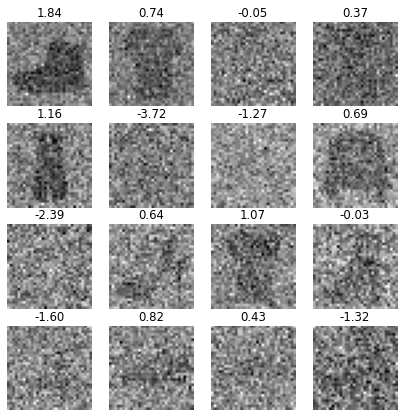

In [27]:
titles = [f'{o:.2f}' for o in amt[:16]]
show_images(xt[:16], imsize=1.8, titles=titles)

Randomizing the alphabar_t, instead of the standard 0 to 1 range, will allow us to better predict the noise given an input image or batch of images.

We can write a small function to initialize a simple, naive model to establish a baseline for our loss measurement.

In [30]:
class f(nn.Module):
    def __init__(self):
        super().__init__()
        self.blah = nn.Linear(1,1)
    def forward(self, x): return torch.full((len(x),), 0.5 )

In [15]:
metrics = MetricsCB()

In [16]:
lr = 1e-2
learn = TrainLearner(f(), dls, F.mse_loss, lr=lr, cbs=metrics)
learn.fit(1, train=False)

{'loss': '3.520', 'epoch': 0, 'train': 'eval'}


In [17]:
F.mse_loss(amt, torch.full(amt.shape, 0.5))

tensor(3.7227)

In [31]:
# Using MSE on inputs and targets which have different shapes will result in an errors/warnings because of broadcasting rules
# A simple workaround is to use flatten() to align the shapes.
def flat_mse(x, y): return F.mse_loss(x.flatten(), y.flatten())

We will be using the same ResNet model architecture from before, however there will only be a single output number since this is effectively a regression model.

In [19]:
def get_model(act=nn.ReLU, nfs=(16, 32, 64, 128, 256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Dropout(0.2), nn.Linear(nfs[-1], 1, bias=False)]
    return nn.Sequential(*layers)

In [20]:
opt_func = partial(optim.Adam, eps=1e-5)
epochs = 20
lr = 1e-2

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
xtra = [BatchSchedCB(sched)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, flat_mse, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.370,0,train
0.160,0,eval
0.156,1,train
0.103,1,eval
0.151,2,train
0.452,2,eval
0.150,3,train
0.810,3,eval
0.155,4,train
0.240,4,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


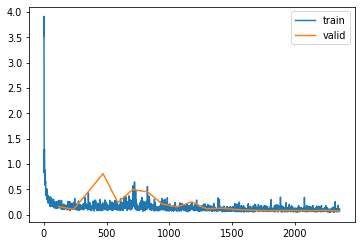

In [21]:
learn.fit(epochs)

Compared to the naive `f()` model, which doesn't learn anything and returns an MSE of 3.7, our ResNet model starts at an MSE of 3.7 and quickly learns following epoch 0.

In [32]:
# Save / Load model
torch.save(learn.model, 'models/noisepred_sig.pkl')
tmodel = learn.model
# tmodel = torch.load('models/noisepred_sig.pkl').cuda()

Now, lets grab a batch of noised images and put them through the `alphabar / t` model and see the prediction for each item.

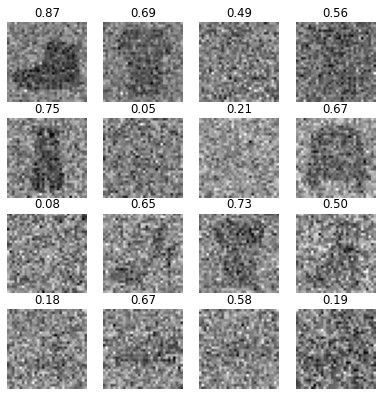

In [33]:
with torch.no_grad(): a = to_cpu(tmodel(xt.cuda()).squeeze())
titles = [f'{o.sigmoid():.2f}' for o in a[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

Now, let's grab the actuals for comparison. This proves that we can predict the noise which was being entered as a manual process. 

This effectively shows that we won't need to pass the `t` each time, thereby adding more flexibility to our sampling process.

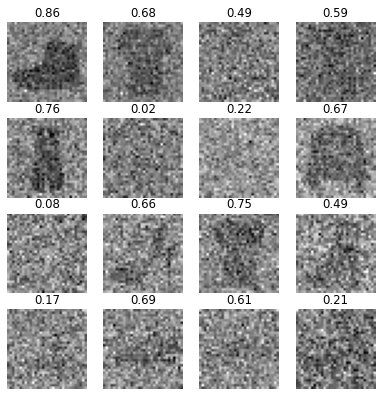

In [34]:
titles = [f'{o.sigmoid():.2f}' for o in amt[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

Time to try our `No-T` approach in a new model.

## **Training a "No-Time" Model**

In [36]:
from diffusers import UNet2DModel
from torch.utils.data import DataLoader,default_collate

In [37]:
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

In [45]:
# Updating the noisify function to return noisified images and not t
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand((n,)).to(x0).clamp(0, 0.999)
    eps = torch.randn(x0.shape).to(x0)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*eps
    return xt, eps

In [46]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [47]:
class UNet(UNet2DModel):
    # Since t has been removed, the UNet is going to pass 0 everytime 
    # Note that the following is the lazier approach to handling this issue.
    def forward(self, x): return super().forward(x,0).sample

In [48]:
# Same as before
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [49]:
lr = 4e-3
epochs = 25
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.396,0,train
0.072,0,eval
0.059,1,train
0.050,1,eval
0.049,2,train
0.046,2,eval
0.046,3,train
0.045,3,eval
0.043,4,train
0.043,4,eval


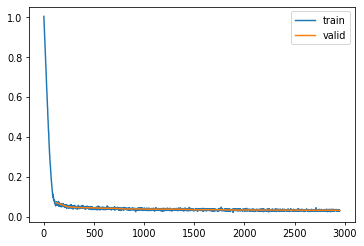

In [50]:
learn.fit(epochs)

In [51]:
torch.save(learn.model, 'models/fashion_no-t.pkl')
#model = learn.model = torch.load('models/fashion_no-t.pkl').cuda()

## **Sampling**

In [54]:
sz = (2048, 1, 32, 32)

In [59]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb, yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [66]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    # Pass the noised image to the tmodel
    # This is the predicted alpha bar for each image.
    with torch.no_grad(): a = tmodel(x_t)[...,None,None].sigmoid()
    # alphabar can have extremely high or low values, so taking the median
    med = a.median()
    # Ensure estimated alphabar is within the range of the median
    a = a.clamp(med/2,med*2)
    # Update based on noise remaining / left behind rather than the assumed value.
    x_0_hat = ((x_t-(1-a).sqrt()*noise) / a.sqrt()).clamp(-2,2)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

Contrasted with the original step, which generated poor quality samples.

In [56]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-0.5, 0.5)
    if bbar_t1 <= sig**2+0.01: sig = 0.
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat

In [67]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1.):
    ts = torch.linspace(1-1/steps, 0, steps)
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i, t in enumerate(progress_bar(ts)): # Note t is not being passed to the model.
        abar_t = abar(t)
        noise = model(x_t) # Passing model(x_t) since there is no t to pass in.
        abar_t1 = abar(t-1/steps) if t >= 1/steps else torch.tensor(1)
        x_0_hat, x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100)) # unpacking two vals.
        preds.append(x_0_hat.float().cpu())
    return preds

In [63]:
set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)

In [64]:
# Using model-t eta 1.0
ie.fid(s),ie.kid(s),s.shape

(10.22857666015625, 0.012541747651994228, torch.Size([2048, 1, 32, 32]))

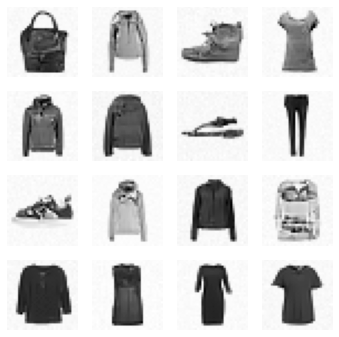

In [65]:
show_images(s[:16], imsize=1.5)

The experiment resulted in outputs which are still pretty noisy and our key metric i.e. FID, deteriorated quite a bit.

Plotting KID for each sample in the reverse diffusion process.

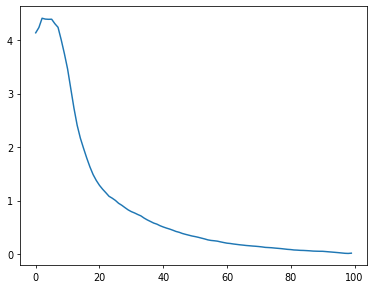

In [68]:
plt.plot([ie.kid((o*2).clamp(-1,1)) for o in preds]);